## Objective: Predict whether a person is an extrovert or introvert based on their responses to behavioral questions.

## 📊 Data Characteristics
- **Dataset Source:** [Extrovert vs. Introvert Behavior Data on Kaggle](https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data)
- The dataset contains answers to a series of survey questions related to:
  - **Lifestyle habits:** like sleep timing, online gaming frequency
  - **Communication preferences:** phone call duration, messaging behavior
  - **Mood and social interactions**

# Import Libraries

In [3]:
# Core libraries
import pandas as pd
import numpy as np
import warnings

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: model selection, preprocessing, metrics, class_weight
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay)
from sklearn.utils import class_weight

# Modeling
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch

# Settings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Jupyter magic
%matplotlib inline

# Load Data

In [5]:
# Load the dataset
train = pd.read_csv(r"C:\Users\ASUS\Downloads\kaggle\train.csv")
test  = pd.read_csv(r"C:\Users\ASUS\Downloads\kaggle\test.csv")

# Add a 'dataset' column to track source
train['dataset'] = 'train'
test['dataset'] = 'test'

# Combine train and test datasets for unified preprocessing
df = pd.concat([train, test], axis=0).reset_index(drop=True)

# Display dataset shape
print("Dataset shape:", df.shape)

# Preview the data
df

Dataset shape: (24699, 10)


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,dataset
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert,train
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert,train
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert,train
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert,train
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert,train
...,...,...,...,...,...,...,...,...,...,...
24694,24694,3.0,No,5.0,5.0,No,9.0,6.0,NaN,test
24695,24695,8.0,Yes,2.0,1.0,Yes,0.0,0.0,NaN,test
24696,24696,2.0,No,4.0,3.0,No,9.0,7.0,NaN,test
24697,24697,3.0,No,4.0,4.0,No,11.0,9.0,NaN,test


In [6]:
train.shape

(18524, 10)

In [7]:
test.shape

(6175, 9)

In [8]:
# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['id', 'Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
Categorical Columns: ['Stage_fear', 'Drained_after_socializing', 'Personality', 'dataset']


In [9]:
# Check for null values
df.isnull().sum()

id                              0
Time_spent_Alone             1615
Stage_fear                   2491
Social_event_attendance      1577
Going_outside                1932
Drained_after_socializing    1581
Friends_circle_size          1404
Post_frequency               1672
Personality                  6175
dataset                         0
dtype: int64

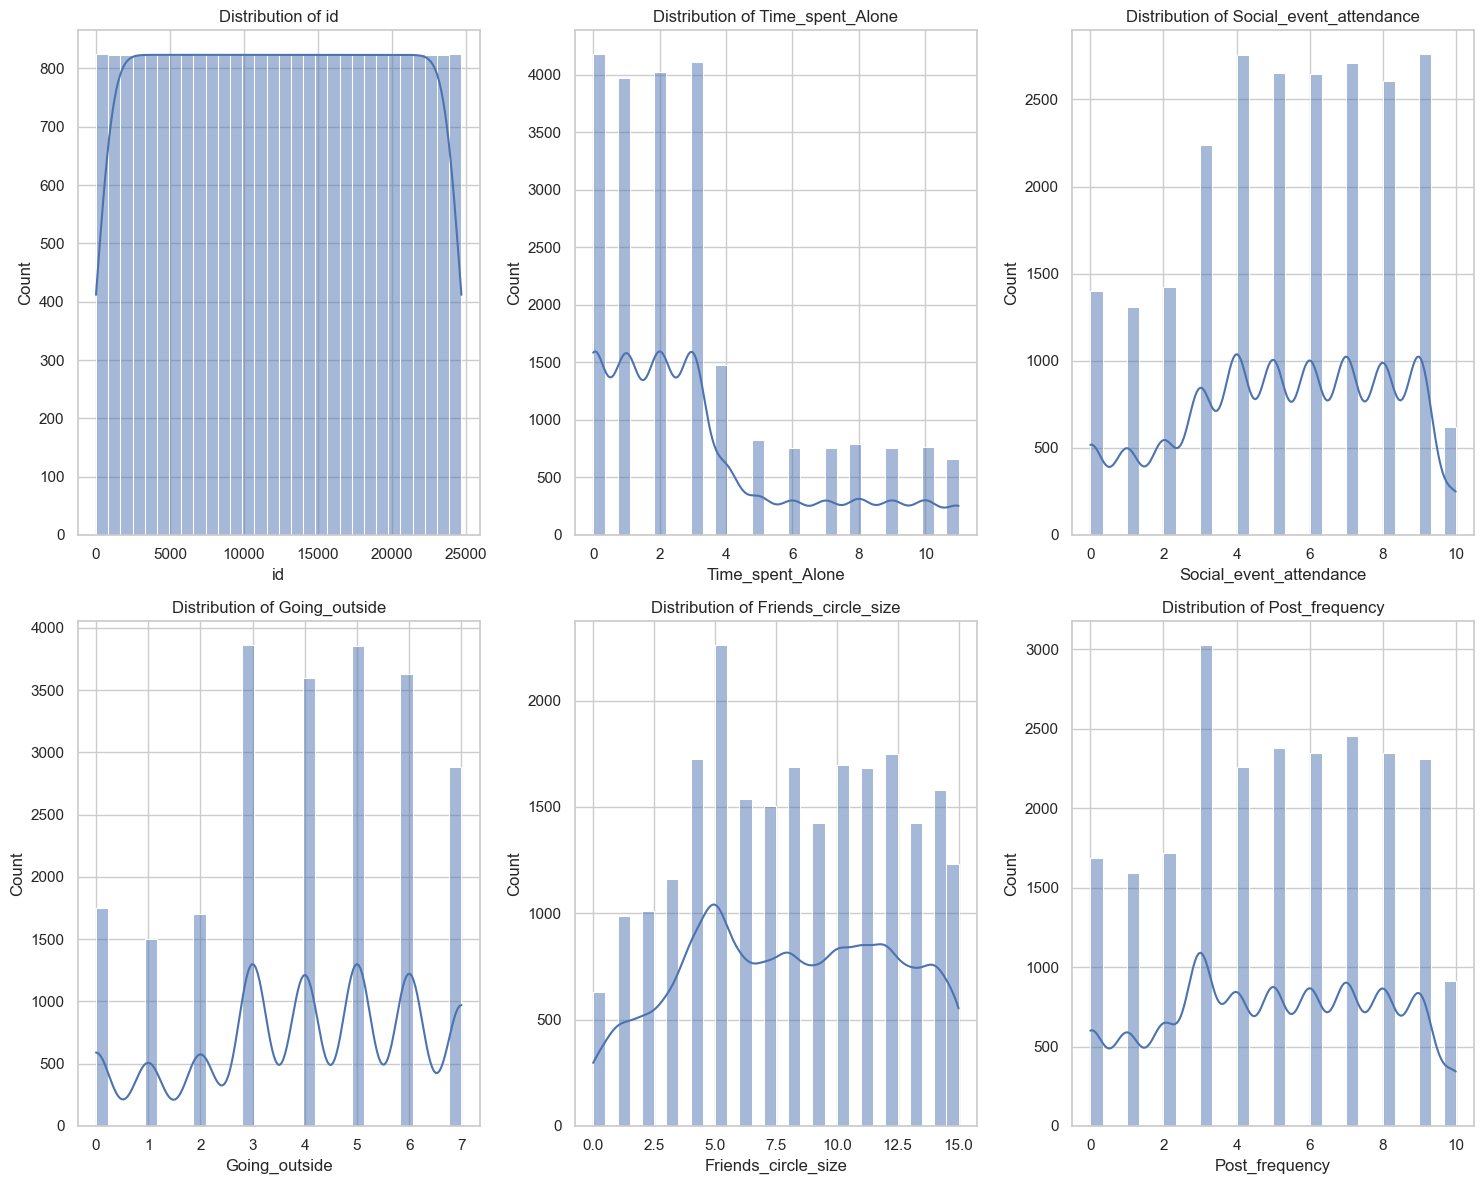

In [10]:
# Checking distribution of data

# Set plot size
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 12))
axes = axes.flatten()

# Plot each numerical column with histogram + KDE curve
for i, col in enumerate(df[numerical_cols].columns):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Adjust layout
plt.tight_layout()
plt.show()

In [11]:
# Descriptive statistics for numerical columns
df[numerical_cols].describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,24699.000000,23084.000000,23122.000000,22767.000000,23295.000000,23027.000000
mean,12349.000000,3.132559,5.270824,4.042693,7.999657,4.993833
std,7130.131485,2.999230,2.754491,2.058194,4.215721,2.876184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6174.500000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,12349.000000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,18523.500000,4.000000,8.000000,6.000000,12.000000,7.000000
max,24698.000000,11.000000,10.000000,7.000000,15.000000,10.000000


# Exploratory Data Analysis (EDA)

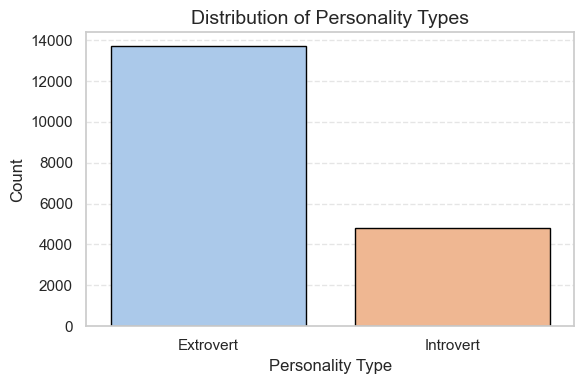


📊 Personality Value Counts (Proportions):
Personality
Extrovert    0.74
Introvert    0.26
Name: proportion, dtype: float64


In [13]:
# 🎯 Target Variable Distribution
# We begin by analyzing the distribution of our target variable, Personality, to see if the dataset is balanced between Extrovert and Introvert.

# ===== Target Variable Distribution =====

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Personality', palette='pastel', edgecolor='black')
plt.title('Distribution of Personality Types', fontsize=14)
plt.xlabel('Personality Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Display normalized value counts (as proportions)
print("\n📊 Personality Value Counts (Proportions):")
print(df['Personality'].value_counts(normalize=True).round(3))

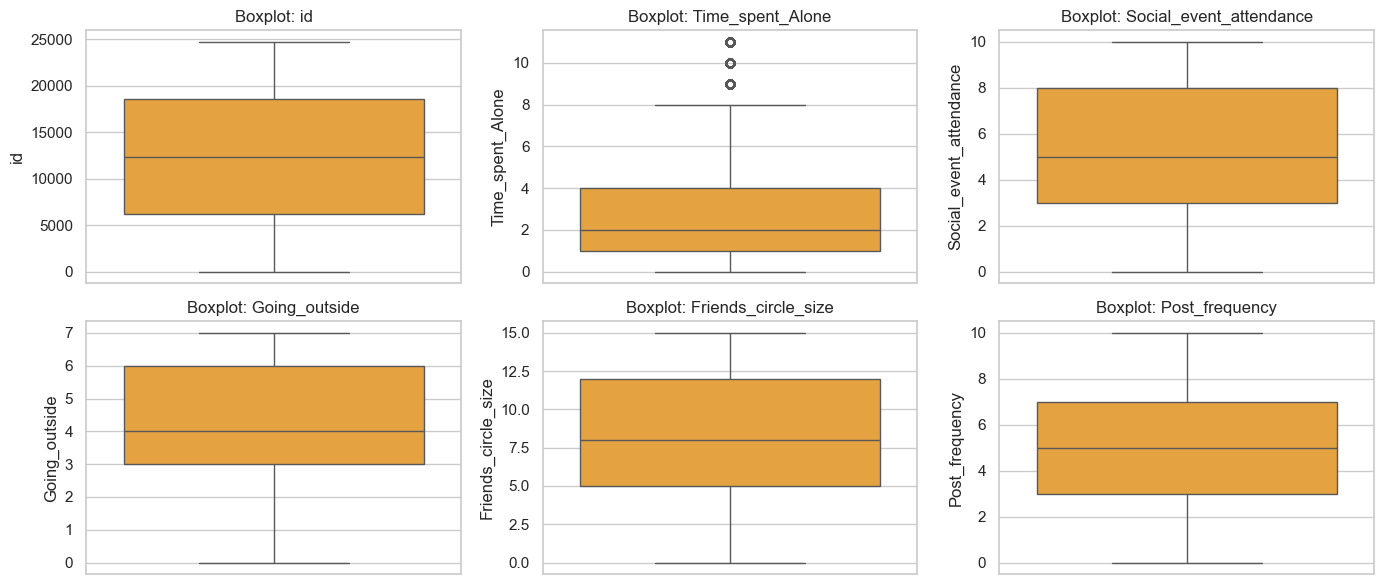

In [14]:
# Outlier Detection via Boxplots

plt.figure(figsize=(14, 6))
for i, col in enumerate(df[numerical_cols].columns):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=df, y=col, color='#FFA726')
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()

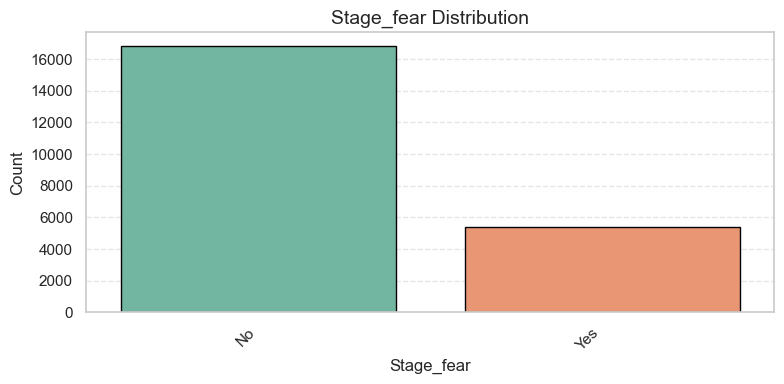


📊 Proportion of Each Category in "Stage_fear":

Stage_fear
No     0.759
Yes    0.241
Name: proportion, dtype: float64 
----------------------------------------


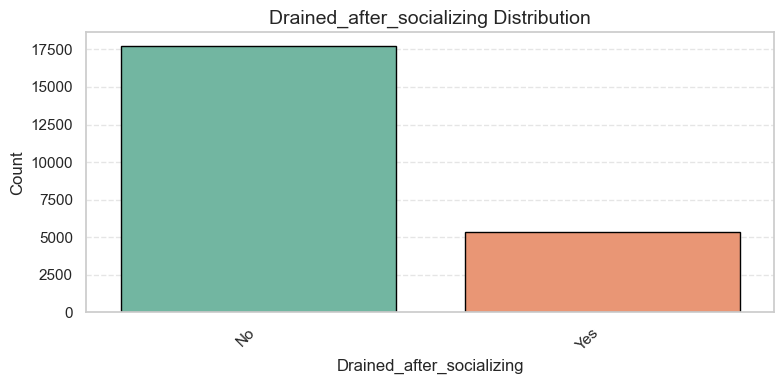


📊 Proportion of Each Category in "Drained_after_socializing":

Drained_after_socializing
No     0.768
Yes    0.232
Name: proportion, dtype: float64 
----------------------------------------


In [15]:
# 📊 Distribution of Categorical Features

cat_cols = ['Stage_fear', 'Drained_after_socializing']

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(
        data=df,
        x=col,
        order=df[col].value_counts().index,
        palette='Set2',
        edgecolor='black'
    )
    plt.title(f'{col} Distribution', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print(f'\n📊 Proportion of Each Category in "{col}":\n')
    print(df[col].value_counts(normalize=True).round(3), '\n' + '-'*40)

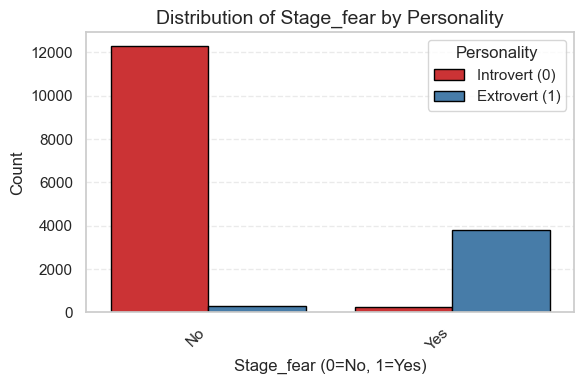

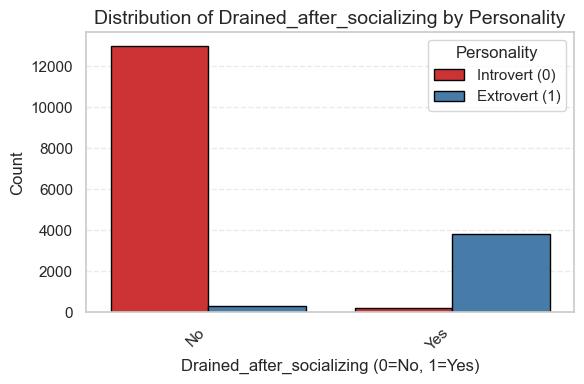

In [16]:
# Categorical Feature Distributions by Personality =====

for col, palette in zip(['Stage_fear', 'Drained_after_socializing'], ['Set1', 'Set1']):
    plt.figure(figsize=(6, 4))
    sns.countplot(
        data=df,
        x=col,
        hue='Personality',
        palette=palette,
        edgecolor='black'
    )
    plt.title(f'Distribution of {col} by Personality', fontsize=14)
    plt.xlabel(f'{col} (0=No, 1=Yes)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Personality', labels=['Introvert (0)', 'Extrovert (1)'])
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

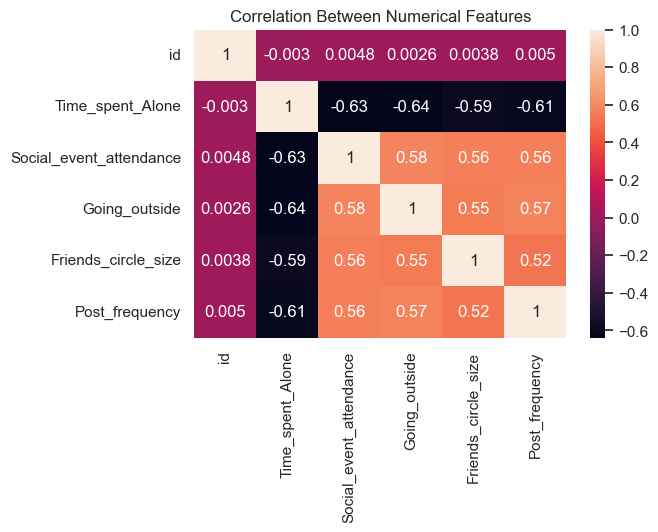

In [17]:
# Correlation Between Numerical Features
# A heatmap is plotted to assess correlations between numerical features, which may influence feature selection or interaction terms later.

plt.figure(figsize=(6, 4))
sns.heatmap(df[numerical_cols].corr(), annot=True)
plt.title("Correlation Between Numerical Features")
plt.show()

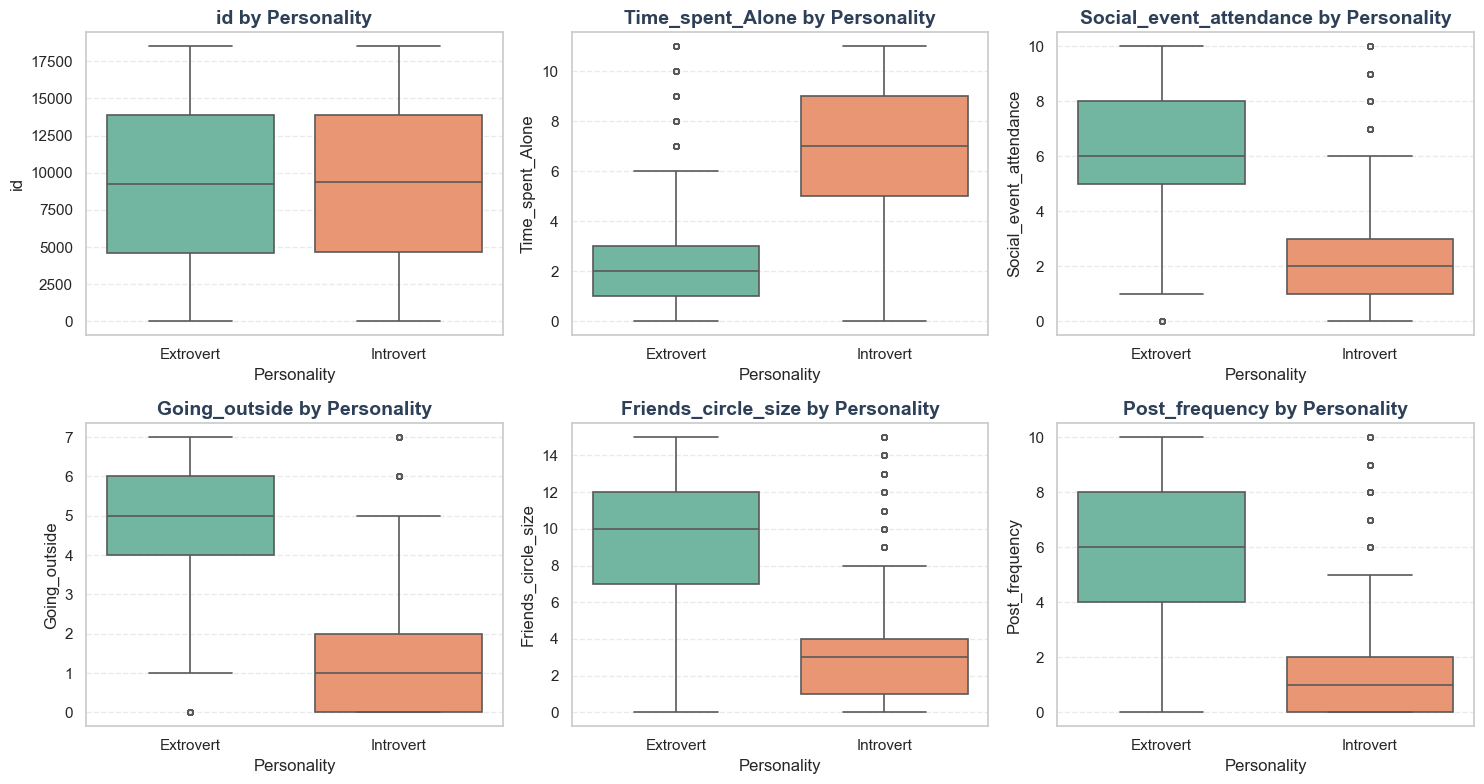

In [18]:
# Feature vs Target Relationship (Numerical Features by Personality)

plt.figure(figsize=(15, 8))
for i, col in enumerate(df[numerical_cols].columns):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(
        data=df,
        x='Personality',
        y=col,
        palette='Set2',
        linewidth=1.2,
        fliersize=4
    )
    plt.title(f'{col} by Personality', fontsize=14, fontweight='semibold', color='#2E4057')
    plt.xlabel('Personality', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

## Summary of EDA Insights

1. **Class Imbalance**  
   - The dataset is skewed toward **Extroverts** (74%) versus **Introverts** (26%), suggesting our model may need to account for this imbalance (e.g., via class weights or resampling).
2. **Time Spent Alone**  
   - On average, individuals spend about **3.13 hours/day** alone (std ≈ 3.00), with values ranging from 0 to 11 hours.  
   - The distribution is right-skewed (median = 2 hrs, 75th percentile = 4 hrs), indicating a minority who spend many hours alone.

3. **Social Event Attendance**  
   - People attend roughly **5.27 social events/month** on average (std ≈ 2.75), with a median of 5 events.  
   - The range spans from 0 up to 10 events, showing wide variability in social engagement.

4. **Outdoor Activity**  
   - Individuals go outside about **4.04 days/week** on average (std ≈ 2.06), with half of users going out on at least 4 days.  
   - Some records report 0 days out (“home-bodies”), while others report daily outdoor activity (7 days/week).

5. **Friends Circle Size**  
   - The average close-friend count is **8** (std ≈ 4.22), ranging from 0 to 15.  
   - The interquartile range [5, 12] suggests most people maintain a moderate-sized social circle.

6. **Social Media Post Frequency**  
   - Users post on social media about **5 times/month** on average (std ≈ 2.88), with a median of 5 posts.  
   - There are both inactive users (0 posts) and highly active ones (up to 10 posts).

7. **Stage Fear & Post-Social Drain**  
   - **24.1%** of respondents report a fear of public speaking (`Stage_fear = Yes`), and **23.2%** feel mentally drained after socializing.  
   - The majority (>75%) do not experience stage fear or post-social drain.

8. **Missing Data Patterns**  
   - There are several missing values in every column.  
   - We will need to impute or otherwise address these gaps before modeling.

---

These insights will guide our next steps in feature engineering (e.g., transforming skewed variables, encoding categorical flags) and inform strategies to handle class imbalance and missing values.  


# Data Preprocessing

In [22]:
# Encoding Categorical Variables

# Convert Stage_fear and Drained_after_socializing from Yes/No to 1/0.
# Convert target variable Personality from Extrovert/Introvert to 1/0.

mapping_yes_no = {'Yes': 1, 'No': 0}
df['Stage_fear'] = df['Stage_fear'].map(mapping_yes_no)
df['Drained_after_socializing'] = df['Drained_after_socializing'].map(mapping_yes_no)

mapping_personality = {'Extrovert': 1, 'Introvert': 0}
df['Personality'] = df['Personality'].map(mapping_personality)

In [23]:
# Separate train and test datasets
train_df = df[df['dataset'] == 'train'].drop(columns=['dataset'], errors='ignore')
test_df  = df[df['dataset'] == 'test'].drop(columns =['dataset'], errors='ignore')


# Drop unnecessary columns from both datasets
train_df = train_df.drop(columns=['id'], errors='ignore')
test_df = test_df.drop(columns=['Personality','id'], errors='ignore')


# Feature and Target Separation

X = train_df.drop('Personality', axis=1)
y = train_df['Personality']

# Modeling

In [28]:
# ========================
# STEP 1: Feature Engineering
# ========================

# Feature Engineering
df["posts_per_friend"] = df["Post_frequency"] / (df["Friends_circle_size"] + 1)

df["social_energy"] = df["Social_event_attendance"] - df["Time_spent_Alone"]
df["social_fatigue"] = df["Time_spent_Alone"] / (df["Social_event_attendance"] + 1)
df["isolation_score"] = df["Time_spent_Alone"] / (df["Friends_circle_size"] + 1)

df["high_events"] = (df["Social_event_attendance"] > df["Social_event_attendance"].median()).astype(int)
df["low_alone_time"] = (df["Time_spent_Alone"] < df["Time_spent_Alone"].median()).astype(int)

# Update new feature list
new_features = [ "posts_per_friend", "social_energy", "social_fatigue", "isolation_score","high_events", "low_alone_time"]

# Apply to train and test
X = df[df["dataset"] == "train"].copy()
test_df = df[df["dataset"] == "test"].copy()
y = X["Personality"]
X = X.drop(columns=["Personality", "dataset"])
test_df = test_df.drop(columns=["Personality", "dataset"], errors='ignore')

X[new_features] = df.loc[df['dataset'] == 'train', new_features]
test_df[new_features] = df.loc[df['dataset'] == 'test', new_features]

# ========================
# STEP 2: Outlier Handling
# ========================

def cap_outliers(df, cols, z_thresh=3):
    for col in cols:
        mean = df[col].mean()
        std = df[col].std()
        upper = mean + z_thresh * std
        lower = mean - z_thresh * std
        df[col] = np.clip(df[col], lower, upper)
    return df

X = cap_outliers(X, X.select_dtypes(include=np.number).columns)
test_df = cap_outliers(test_df, test_df.select_dtypes(include=np.number).columns)

# ========================
# STEP 3: Polynomial Interactions
# ========================

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_feats = poly.fit_transform(X[new_features])
poly_feature_names = poly.get_feature_names_out(new_features)
poly_df = pd.DataFrame(poly_feats, columns=poly_feature_names, index=X.index)
X = pd.concat([X, poly_df], axis=1)

test_poly_df = pd.DataFrame(poly.transform(test_df[new_features]), columns=poly_feature_names, index=test_df.index)
test_df = pd.concat([test_df, test_poly_df], axis=1)

# ========================
# STEP 4: Scale
# ========================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_df)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# ========================
# STEP 5: TabNet Pretraining (Optional)
# ========================

unsupervised_model = TabNetPretrainer()
unsupervised_model.fit(X_train=X_scaled)

# ========================
# STEP 6: Fine-Tuned TabNetClassifier
# ========================

clf = TabNetClassifier(
    n_d=32,               # Dimensionality of the decision prediction layer
    n_a=32,               # Dimensionality of the attention layer
    n_steps=5,            # Number of steps in the architecture
    gamma=1.5,            # Relaxation parameter
    lambda_sparse=1e-4,   # Sparsity regularization
    optimizer_fn=torch.optim.Adam,  # You can try AdamW, RMSprop
    optimizer_params=dict(lr=1e-2),  # Learning rate
    scheduler_params={
        "step_size": 10,       # Every 10 epochs
        "gamma": 0.9           # Decay LR by 10%
    },
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="entmax",    # 'sparsemax' or 'entmax'
    verbose=1,
    seed=42
)

clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_name=["val"],
    eval_metric=["accuracy"],
    max_epochs=200,
    patience=15,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    from_unsupervised=unsupervised_model
)

# Eval
y_pred = clf.predict(X_val)
print("Val Accuracy with Selected Features:", accuracy_score(y_val, y_pred))

epoch 0  | loss: 1.66759 |  0:00:01s
epoch 1  | loss: 0.7178  |  0:00:02s
epoch 2  | loss: 0.56371 |  0:00:04s
epoch 3  | loss: 0.47174 |  0:00:05s
epoch 4  | loss: 0.42652 |  0:00:06s
epoch 5  | loss: 0.39694 |  0:00:07s
epoch 6  | loss: 0.37473 |  0:00:09s
epoch 7  | loss: 0.35701 |  0:00:10s
epoch 8  | loss: 0.34796 |  0:00:11s
epoch 9  | loss: 0.33466 |  0:00:12s
epoch 10 | loss: 0.33033 |  0:00:13s
epoch 11 | loss: 0.31426 |  0:00:15s
epoch 12 | loss: 0.30964 |  0:00:16s
epoch 13 | loss: 0.30158 |  0:00:17s
epoch 14 | loss: 0.29214 |  0:00:18s
epoch 15 | loss: 0.28271 |  0:00:19s
epoch 16 | loss: 0.27794 |  0:00:21s
epoch 17 | loss: 0.2717  |  0:00:22s
epoch 18 | loss: 0.26724 |  0:00:23s
epoch 19 | loss: 0.25612 |  0:00:24s
epoch 20 | loss: 0.25946 |  0:00:25s
epoch 21 | loss: 0.25032 |  0:00:26s
epoch 22 | loss: 0.24873 |  0:00:27s
epoch 23 | loss: 0.24551 |  0:00:28s
epoch 24 | loss: 0.24119 |  0:00:30s
epoch 25 | loss: 0.23552 |  0:00:31s
epoch 26 | loss: 0.23142 |  0:00:32s
e

# Preparing submission file

In [34]:
# Inverse mapping
inverse_mapping_personality = {v: k for k, v in mapping_personality.items()}

# Predict and decode
test_preds_encoded = clf.predict(test_scaled)
test_preds = [inverse_mapping_personality[pred] for pred in test_preds_encoded]

# Create submission
submission = pd.DataFrame({
    "id": test_df.index,
    "Personality": test_preds
})

# Save submission
submission.to_excel("tabnet_submission.xlsx", index=False)